In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Libraries##


In [1]:
# Data manipulation and processing
import numpy as np
import pandas as pd
from collections import defaultdict

# Text processing and NLP
import re
import string
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# %matplotlib inline

# Machine Learning and Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score,recall_score,f1_score,classification_report,accuracy_score,confusion_matrix,roc_curve,auc)
from keras.models import Sequential
from keras.layers import (LSTM,Embedding,BatchNormalization,Dense,TimeDistributed,Dropout,Bidirectional,Flatten,GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load Datasets##

In [4]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Disaster Tweets/train.csv", encoding="latin-1")
test_dataset = pd.read_csv("/content/drive/MyDrive/Disaster Tweets/test.csv", encoding="latin-1")

In [5]:
train_dataset

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
test_dataset

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


##Handling Missing Values##

In [7]:
print(train_dataset.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
train_dataset = train_dataset.dropna(how="any", axis=1)
train_dataset['text_len'] = train_dataset['text'].apply(lambda x: len(x.split(' ')))

train_dataset

<ipython-input-8-b3731fb264e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['text_len'] = train_dataset['text'].apply(lambda x: len(x.split(' ')))


,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,10872,Police investigating after an e-bike collided ...,1,19


##EDA##


In [9]:
groups = train_dataset.groupby('target')['target'].agg('count').values
groups

array([4342, 3271])

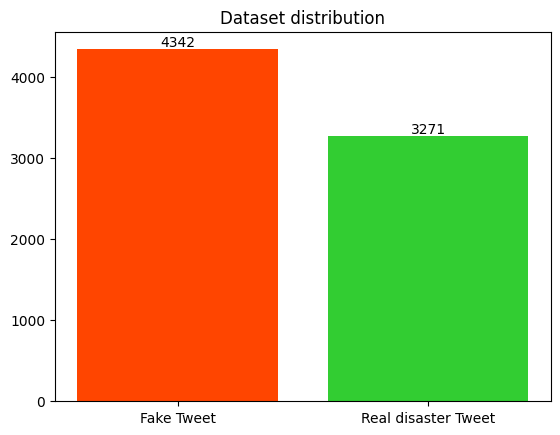

In [11]:
x = ['Fake Tweet', 'Real disaster Tweet']
y = [groups[0], groups[1]]
colors = ['#FF4500', '#32CD32']

# Create figure and bar chart with colors
fig, ax = plt.subplots()
bars = ax.bar(x, y, color=colors)
# Adding text labels on bars
for bar, value in zip(bars, y):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Position x of the text
        bar.get_height(),                   # Position and of the text (above the bar)
        f'{value}',                         # Text with the value
        ha='center', va='bottom'            # Horizontal and vertical alignment
    )
plt.title('Dataset distribution')
plt.show()

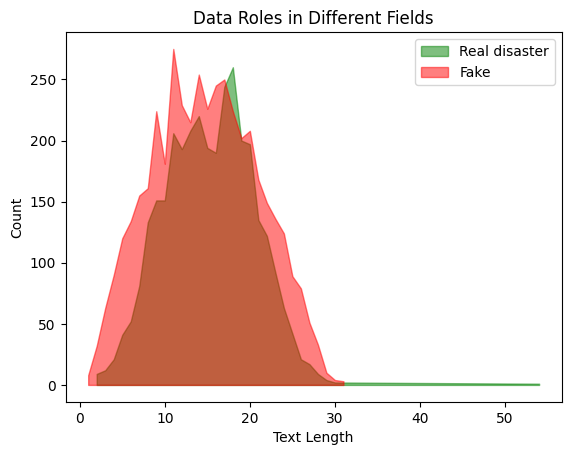

In [12]:
# Filtering and counting the length of texts for each category
disaster = train_dataset[train_dataset['target'] == 1]['text_len'].value_counts().sort_index()
fake = train_dataset[train_dataset['target'] == 0]['text_len'].value_counts().sort_index()

# Create the figure and axes
fig, ax = plt.subplots()

# Plot lines with filled areas
ax.fill_between(disaster.index, disaster.values, alpha=0.5, label='Real disaster', color='green')
ax.fill_between(fake.index, fake.values, alpha=0.5, label='Fake', color='red')

ax.set_title('Data Roles in Different Fields')
ax.set_xlabel('Text Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

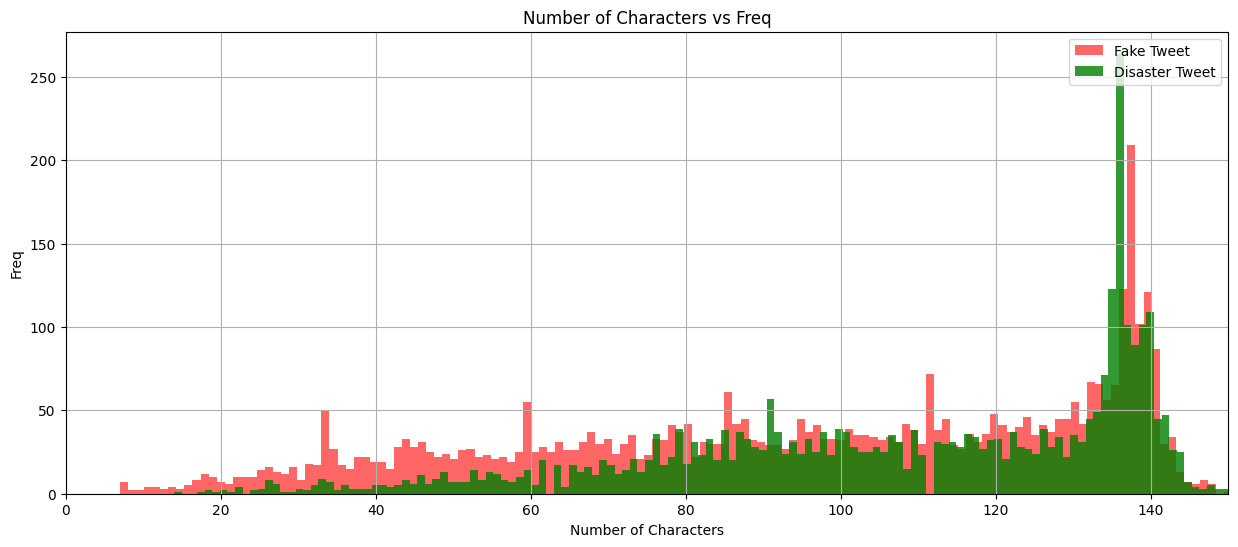

In [13]:
def length(text):
    return len(text)

train_dataset['c_length'] = train_dataset['text'].apply(length)

plt.rcParams['figure.figsize'] = (15.0, 6.0)
bins = 150
plt.hist(train_dataset[train_dataset['target'] == 0]['c_length'], alpha=0.6, bins=bins, color='red', label='Fake Tweet')
plt.hist(train_dataset[train_dataset['target'] == 1]['c_length'], alpha=0.8, bins=bins, color='green', label='Disaster Tweet')
plt.title('Number of Characters vs Freq')
plt.xlabel('Number of Characters')
plt.ylabel('Freq')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

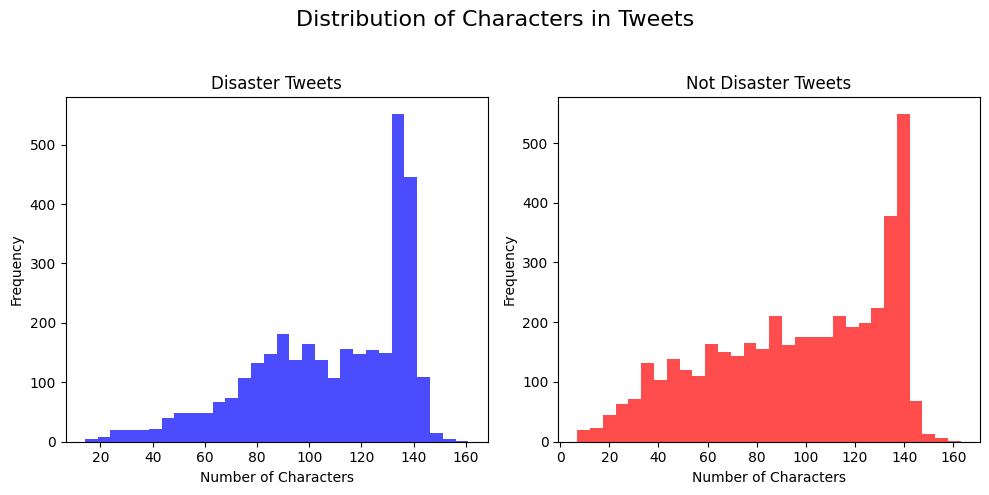

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram for disaster tweets
tweet_len = train_dataset[train_dataset['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color='blue', bins=30, alpha=0.7)
ax1.set_title('Disaster Tweets')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

# Histogram for non-disaster tweets.
tweet_len = train_dataset[train_dataset['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color='red', bins=30, alpha=0.7)
ax2.set_title('Not Disaster Tweets')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')


fig.suptitle('Distribution of Characters in Tweets', fontsize=16)

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##Preprocessing Dataset##

Remove words that do not provide information

In [15]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

In [16]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # Emoticons
        u'\U0001F300-\U0001F5FF'  # Symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # Transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # Flags (iOS)
        u'\U00002702-\U000027B0'  # Miscellaneous symbols
        u'\U000024C2-\U0001F251'  # Other symbols
        ']+',
        flags=re.UNICODE
    )
    return emoji_pattern.sub('', text)

In [17]:
def remove_html_tags(text):
    html_pattern = re.compile(r'<.*?>|&(?:[a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html_pattern.sub('', text)

In [18]:
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [26]:
def preprocess_text(input_text):
  # replace abbreviations with their long form
    cleaned_text = str(input_text)
    cleaned_text = re.sub(r"\bI'm\b", "I am", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\byou're\b", "you are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bthey're\b", "they are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bcan't\b", "cannot", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bwon't\b", "will not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bdon't\b", "do not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bdoesn't\b", "does not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bain't\b", "am not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bwe're\b", "we are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bit's\b", "it is", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bu\b", "you", cleaned_text, flags=re.IGNORECASE)

    cleaned_text = re.sub(r"&gt;", ">", cleaned_text)
    cleaned_text = re.sub(r"&lt;", "<", cleaned_text)
    cleaned_text = re.sub(r"&amp;", "&", cleaned_text)

    # Correction of common errors and relevant abbreviations
    cleaned_text = re.sub(r"\bw/\b", "with", cleaned_text)  # "w/" → "with"
    cleaned_text = re.sub(r"\blmao\b", "laughing my ass off", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"<3", "love", cleaned_text)  # Corazón → "love"
    cleaned_text = re.sub(r"\bph0tos\b", "photos", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bamirite\b", "am I right", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\btrfc\b", "traffic", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\b16yr\b", "16 year", cleaned_text)

    cleaned_text = str(cleaned_text).lower()  # Convert to lowercase

    # Remove unwanted patterns
    cleaned_text = re.sub(r'\[.*?\]', '', cleaned_text)  # Remove content inside brackets
    cleaned_text = re.sub(r'\n', ' ', cleaned_text)  # Replace newlines with spaces
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)  # Remove words with numbers

    cleaned_text = remove_urls(cleaned_text)  # Remove URLs
    cleaned_text = remove_emojis(cleaned_text)  # Remove emojis
    cleaned_text = remove_html_tags(cleaned_text)  # Remove HTML tags
    cleaned_text = remove_punctuation(cleaned_text)  # Remove punctuation

    return cleaned_text

In [27]:
# Download resources needed for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()  # <-- We use lemmatizer

# Add additional context-specific words
extra_stop_words = ['u', 'im', 'r']  # Common abbreviations
extra_stop_words2 = [
    'u', 'im', 'r', 'ur', 'pls', 'thx',  # Common abbreviations
    'b4', 'omw', 'ppl', 'msg', 'lvl',    # Fast communication
    'sos', '911', 'help', 'asap',        # Emergencies
    'wtf', 'omg', 'idk', 'nvm',          # Emotional reactions
    'brb', 'btw', 'lmk', 'imo',          # Rapid coordination
    'stay', 'safe', 'evacuate', 'fyi'    # Indications and recommendations
]

all_stop_words = stop_words_list + extra_stop_words + extra_stop_words2 # Combine both stop word lists
word_stemmer = nltk.SnowballStemmer("english") # Create a SnowballStemmer object for English language

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def process_tweet_content(tweet):
    cleaned_tweet = preprocess_text(tweet) # Clean up text by removing URLs, punctuation, HTML, etc.
    processed_tweet = ' '.join(lemmatizer.lemmatize(word) for word in cleaned_tweet.split() if word not in stop_words_list) # Eliminating stopwords and applying lemmatization instead of stemming

    return processed_tweet

In [29]:
train_dataset['text_clean'] = train_dataset['text'].apply(process_tweet_content)
train_dataset

,id,text,target,text_len,c_length,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,133,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,65,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,88,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11,83,two giant crane holding bridge collapse nearby...
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20,125,ariaahrary thetawniest control wild fire calif...
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,65,volcano hawaii
7611,10872,Police investigating after an e-bike collided ...,1,19,137,police investigating ebike collided car little...


In [30]:
test_dataset['text_clean'] = test_dataset['text'].apply(process_tweet_content)
test_dataset

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...,earthquake safety los angeles âãã safety fa...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city hardest hit...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo


##Corpus##

In [31]:
def build_corpus_from_df(dataframe, target_value):
    #Build a corpus of words from the given dataframe based on the target value.
    corpus = []

    # Filter tweets by target value and split into words.
    for words in dataframe[dataframe['target'] == target_value]['text_clean'].str.split():
        for word in words:
            corpus.append(word)

    return corpus

In [32]:
disaster_corpus = build_corpus_from_df(train_dataset, 1)
word_frequency = defaultdict(int) # Initializing a dictionary to count word frequency
# Counting the frequency of each word in the corpus of disaster tweets.
for word in disaster_corpus:
    word_frequency[word] += 1

top_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the words by frequency in descending order and take the 10 most frequent ones
top_words # Display the 10 most frequent words

[('fire', 262),
 ('news', 136),
 ('via', 121),
 ('disaster', 118),
 ('california', 115),
 ('year', 112),
 ('suicide', 110),
 ('people', 106),
 ('police', 106),
 ('family', 105)]

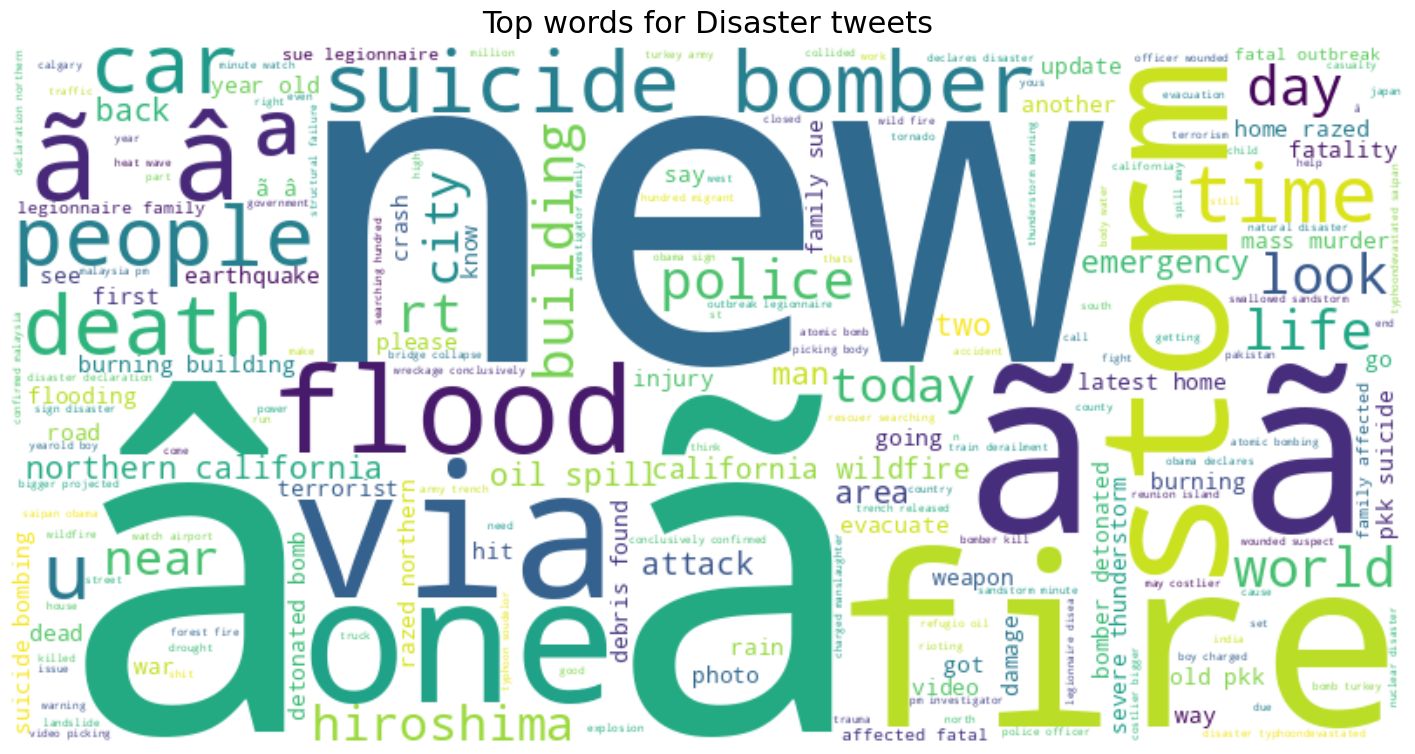

In [34]:
word_cloud = WordCloud( background_color='white', max_words=200, width=800, height=400)  # Adjust image size, max words


text = ' '.join(train_dataset.loc[train_dataset['target'] == 1, 'text_clean']) # Generate word cloud with real disaster tweets.
word_cloud.generate(text)

# Configuring and displaying the word cloud
plt.figure(figsize=(18, 10))
plt.title('Top words for Disaster tweets',fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
print(word_cloud.words_.keys())

dict_keys(['â ã', 'new', 'fire', 'ã ã', 'via', 'storm', 'one', 'flood', 'ã âª', 'suicide bomber', 'car', 'people', 'death', 'time', 'u', 'police', 'look', 'building', 'day', 'world', 'rt', 'life', 'hiroshima', 'near', 'city', 'today', 'northern california', 'emergency', 'area', 'two', 'oil spill', 'man', 'back', 'attack', 'california wildfire', 'burning building', 'damage', 'fatality', 'suicide bombing', 'flooding', 'say', 'go', 'year old', 'hit', 'bomber detonated', 'got', 'dead', 'know', 'burning', 'terrorist', 'home razed', 'rain', 'see', 'road', 'another', 'weapon', 'going', 'evacuate', 'severe thunderstorm', 'mass murder', 'latest home', 'razed northern', 'pkk suicide', 'detonated bomb', 'earthquake', 'first', 'injury', 'ã â', 'old pkk', 'photo', 'update', 'crash', 'please', 'way', 'war', 'video', 'debris found', 'family sue', 'sue legionnaire', 'legionnaire family', 'family affected', 'affected fatal', 'fatal outbreak', 'outbreak legionnaire', 'casualty', 'collided', 'atomic bomb

In [36]:
corpus_disaster_tweets_fake = build_corpus_from_df(train_dataset, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets_fake:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 255),
 ('get', 185),
 ('new', 168),
 ('one', 136),
 ('body', 116),
 ('time', 103),
 ('love', 100),
 ('via', 99),
 ('would', 97),
 ('day', 96)]

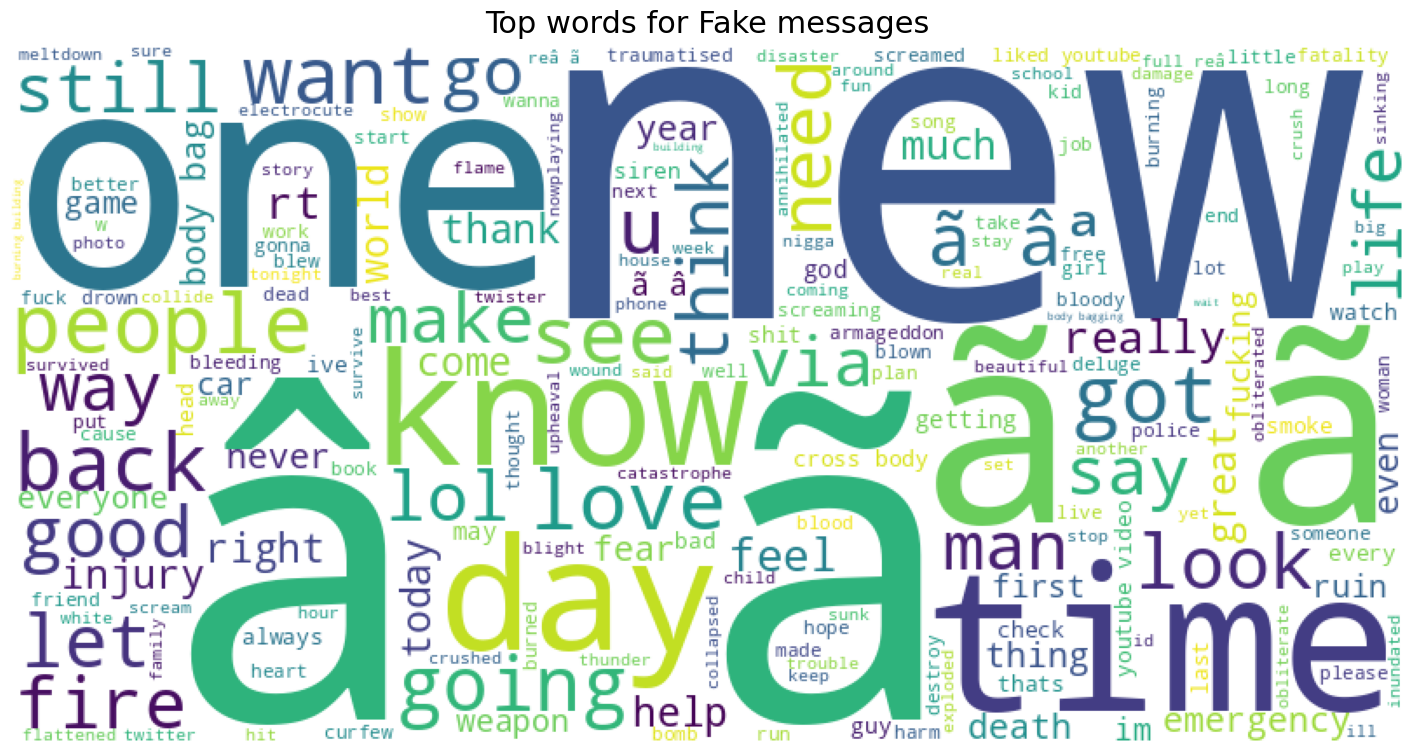

In [37]:
word_cloud2 = WordCloud(background_color='white',max_words=200,width=800,height=400)
word_cloud2.generate(' '.join(text for text in train_dataset.loc[train_dataset['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages',fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(word_cloud2)
plt.axis("off")
plt.show()

In [38]:
print(word_cloud2.words_.keys())

dict_keys(['new', 'â ã', 'one', 'ã ã', 'time', 'know', 'day', 'people', 'love', 'see', 'got', 'want', 'back', 'u', 'going', 'look', 'ã âª', 'need', 'let', 'think', 'good', 'fire', 'still', 'via', 'say', 'man', 'go', 'make', 'lol', 'way', 'life', 'really', 'feel', 'rt', 'injury', 'right', 'help', 'come', 'thank', 'world', 'today', 'great', 'much', 'thing', 'emergency', 'death', 'body bag', 'fear', 'never', 'year', 'even', 'everyone', 'weapon', 'ã â', 'first', 'game', 'fucking', 'car', 'im', 'ruin', 'getting', 'god', 'may', 'cross body', 'shit', 'last', 'guy', 'smoke', 'always', 'check', 'head', 'ive', 'watch', 'youtube video', 'every', 'siren', 'thats', 'bad', 'liked youtube', 'someone', 'bloody', 'hope', 'better', 'armageddon', 'fuck', 'made', 'work', 'plan', 'free', 'screaming', 'well', 'gonna', 'girl', 'burning', 'song', 'blew', 'w', 'screamed', 'traumatised', 'job', 'run', 'lot', 'little', 'put', 'harm', 'deluge', 'end', 'cause', 'live', 'destroy', 'take', 'start', 'friend', 'show',

## Cleaning - Second Round ##

In [39]:
custom_words = {'im', 'u','â', 'ã', 'one', 'ã ã', 'ã ã', 'ã âª', 'ã â', 'â ã', 'â', 'âª','â', 'ã','aaa', 'rt','aa', 'ye'}# List of specific words to be deleted

def normalize_text(text):
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') # Normalize to NFKD form and remove non-ASCII characters
    return normalized_text

def remove_specific_words(tweet):
    tweet = normalize_text(tweet) # Normalize text to avoid coding problems
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)).lower() # Remove punctuation and convert to lowercase
    cleaned_tweet = ' '.join(word for word in tweet.split() if word not in custom_words) # Filter out unwanted words

    return cleaned_tweet

train_dataset['text_clean'] = train_dataset['text_clean'].apply(remove_specific_words) # Apply the function to the DataFrame in the column 'text_clean'.

In [40]:
disaster_corpus = build_corpus_from_df(train_dataset, 1)
word_frequency = defaultdict(int) # Initializing a dictionary to count word frequency

# Counting the frequency of each word in the corpus of disaster tweets.
for word in disaster_corpus:
    word_frequency[word] += 1

top_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the words by frequency in descending order and take the 10 most frequent ones
top_words # Display the 10 most frequent words

[('fire', 262),
 ('news', 136),
 ('via', 121),
 ('disaster', 118),
 ('california', 115),
 ('year', 112),
 ('suicide', 110),
 ('people', 106),
 ('police', 106),
 ('family', 105)]

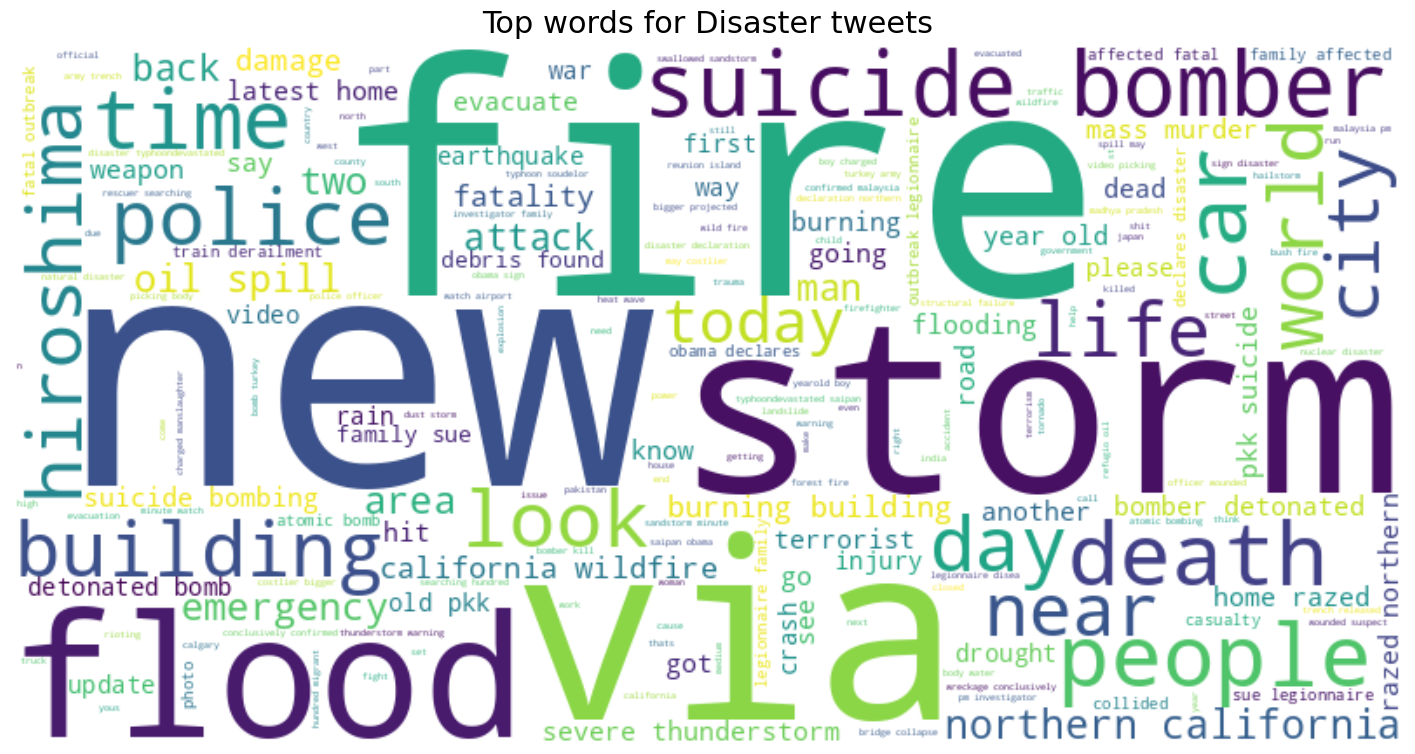

In [41]:
word_cloud = WordCloud(background_color='white', max_words=200, width=800, height=400)
text = ' '.join(train_dataset.loc[train_dataset['target'] == 1, 'text_clean']) # Generate word cloud with real disaster tweets.
word_cloud.generate(text)

# Configuring and displaying the word cloud
plt.figure(figsize=(18, 10))
plt.title('Top words for Disaster tweets',fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
print(word_cloud.words_.keys())

dict_keys(['new', 'fire', 'via', 'storm', 'flood', 'suicide bomber', 'car', 'people', 'death', 'time', 'police', 'look', 'building', 'day', 'world', 'life', 'hiroshima', 'city', 'near', 'today', 'northern california', 'emergency', 'area', 'two', 'oil spill', 'man', 'back', 'attack', 'california wildfire', 'burning building', 'damage', 'fatality', 'suicide bombing', 'flooding', 'say', 'go', 'year old', 'hit', 'bomber detonated', 'got', 'dead', 'know', 'burning', 'terrorist', 'home razed', 'see', 'road', 'another', 'weapon', 'going', 'evacuate', 'severe thunderstorm', 'mass murder', 'latest home', 'razed northern', 'pkk suicide', 'detonated bomb', 'earthquake', 'rain', 'first', 'injury', 'old pkk', 'update', 'crash', 'please', 'way', 'war', 'video', 'drought', 'debris found', 'family sue', 'sue legionnaire', 'legionnaire family', 'family affected', 'affected fatal', 'fatal outbreak', 'outbreak legionnaire', 'photo', 'casualty', 'collided', 'atomic bomb', 'train derailment', 'obama declar

In [43]:
corpus_disaster_tweets_fake = build_corpus_from_df(train_dataset, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets_fake:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 255),
 ('get', 185),
 ('new', 168),
 ('body', 116),
 ('time', 103),
 ('love', 100),
 ('via', 99),
 ('would', 97),
 ('day', 96),
 ('video', 96)]

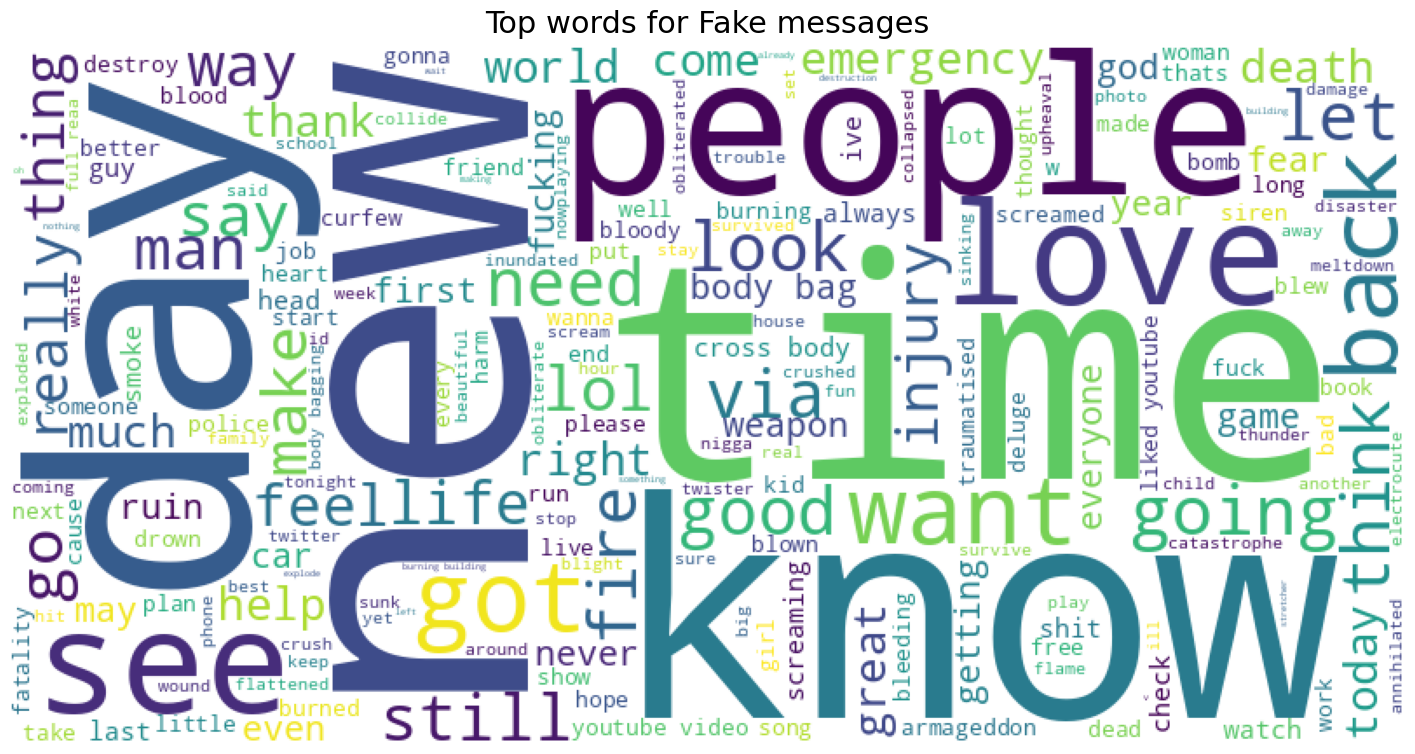

In [44]:
word_cloud2 = WordCloud(background_color='white',max_words=200,width=800,height=400)
word_cloud2.generate(' '.join(text for text in train_dataset.loc[train_dataset['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages', fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(word_cloud2)
plt.axis("off")
plt.show()

In [45]:
print(word_cloud2.words_.keys())

dict_keys(['new', 'time', 'know', 'day', 'people', 'love', 'see', 'got', 'want', 'back', 'going', 'look', 'let', 'need', 'via', 'think', 'good', 'fire', 'still', 'say', 'man', 'go', 'make', 'lol', 'way', 'life', 'really', 'feel', 'injury', 'thing', 'right', 'help', 'come', 'thank', 'world', 'today', 'great', 'much', 'emergency', 'death', 'body bag', 'fear', 'never', 'year', 'even', 'everyone', 'weapon', 'first', 'game', 'fucking', 'car', 'ruin', 'getting', 'god', 'may', 'cross body', 'shit', 'last', 'guy', 'screaming', 'smoke', 'always', 'check', 'head', 'ive', 'watch', 'youtube video', 'every', 'siren', 'thats', 'please', 'bad', 'liked youtube', 'someone', 'bloody', 'hope', 'better', 'armageddon', 'fuck', 'made', 'work', 'free', 'well', 'gonna', 'girl', 'burning', 'song', 'blew', 'w', 'screamed', 'traumatised', 'plan', 'job', 'run', 'lot', 'little', 'put', 'harm', 'deluge', 'end', 'cause', 'live', 'destroy', 'take', 'start', 'friend', 'show', 'wanna', 'bleeding', 'fatality', 'dead', '

Repeated words

In [46]:
# Get the words from both word clouds
words_wc2 = set(word_cloud2.words_.keys())
words_wc = set(word_cloud.words_.keys())

common_words = words_wc2.intersection(words_wc)# Find the repeated words in both variables

print(f"Common Words ({len(common_words)}):") # Print common words
print(common_words)

Common Words (57):
{'please', 'child', 'got', 'know', 'help', 'world', 'going', 'end', 'weapon', 'work', 'cause', 'death', 'thats', 'damage', 'shit', 'injury', 'set', 'new', 'life', 'way', 'burning building', 'getting', 'fire', 'burning', 'hit', 'today', 'car', 'emergency', 'see', 'time', 'another', 'think', 'fatality', 'go', 'look', 'house', 'dead', 'next', 'make', 'year', 'right', 'say', 'via', 'people', 'day', 'building', 'back', 'man', 'woman', 'first', 'come', 'even', 'run', 'photo', 'police', 'need', 'still'}


#Implement GloVe LSTM##


In [47]:
train_tweets = train_dataset['text_clean'].values
test_tweets = test_dataset['text_clean'].values
train_target = train_dataset['target'].values

In [48]:
test_dataset

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...,earthquake safety los angeles âãã safety fa...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city hardest hit...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo


In [49]:
tweet_tokenizer = Tokenizer()
tweet_tokenizer.fit_on_texts(train_tweets) # Adjust the tokenizer to the texts of training tweets.
vocabulary_size = len(tweet_tokenizer.word_index) + 1 # Calculate the length of the vocabulary
print(f"Length of the vocabulary: {vocabulary_size}") # Print vocabulary size

Length of the vocabulary: 15192


In [50]:
# Converting corpus to sequences of integers
def tokenize_corpus(corpus):
    #Embed the corpus into sequences using the trained tokenizer.
    return tweet_tokenizer.texts_to_sequences(corpus)

In [51]:
nltk.download('punkt')
max_length = max(len(word_tokenize(tweet)) for tweet in train_tweets)

train_sentences = pad_sequences(tokenize_corpus(train_tweets),maxlen=max_length,padding='post') # Converting and filling in numerical sequences for training and testing
test_sentences = pad_sequences(tokenize_corpus(test_tweets), maxlen=max_length, padding='post') # This point must be reached in order to give model predictions.

# Verify the result
print(train_sentences)

print()

print(test_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[[3929  437  145 ...    0    0    0]
 [  98    1  138 ...    0    0    0]
 [1494 1366 1844 ...    0    0    0]
 ...
 [ 432 1354    0 ...    0    0    0]
 [  16  965 2780 ...    0    0    0]
 [ 124   17  436 ...    0    0    0]]

[[ 744 1677   38 ...    0    0    0]
 [ 353  145 1016 ...    0    0    0]
 [  98    1  609 ...    0    0    0]
 ...
 [ 802  543  260 ...    0    0    0]
 [5344  263  367 ...    0    0    0]
 [5072 2439 1355 ...    0    0    0]]


In [53]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/drive/MyDrive/Disaster Tweets/globe_LSTM.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions


embedding_matrix = np.zeros((vocabulary_size, embedding_dim)) # embeddings_dictionary

# Filling the matrix with the existing word vectors
for word, idx in tweet_tokenizer.word_index.items():
    if (embedding_vector := embeddings_dictionary.get(word)) is not None:
        embedding_matrix[idx] = embedding_vector

# Verify the result
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.26872    -0.15542001 -0.23565    ...  0.49344     0.72114003
  -0.041749  ]
 [-0.2687      0.81708002  0.69896001 ... -0.40110001  0.74656999
   0.31121999]
 ...
 [ 0.19814    -0.33517    -0.13950001 ... -0.070356   -0.18391
   0.62439001]
 [-0.25161999  0.73246998  0.30792999 ... -0.89315999  1.29760003
  -0.04898   ]
 [-0.34132001  0.26423001  0.47813001 ... -0.92395002  0.48275
   0.52947998]]


In [54]:
X_train, X_test, y_train, y_test = train_test_split(train_sentences,train_target,test_size=0.20, random_state=42)

In [55]:

def lstm():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix],trainable=False)) # embedding layer with pre-trained weights


    model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))) # Bidirectional LSTM layer with regularization # Optimized number of units # Adds dropout for input
    model.add(GlobalMaxPool1D()) # Global Max Pooling Layer for dimensionality reduction
    model.add(BatchNormalization()) # Add Batch Normalization to stabilize the learning process

    # Dense layers with Dropout to avoid overfitting
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))  # reduce the dropout in the second layer

    model.add(Dense(1, activation='sigmoid')) # Output layer for binary classification

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [56]:
model = lstm()
c_point = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6) # Reduce the learning rate if validation is not improved
stop = EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True) # Stopping early if there is no improvement in performance
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[c_point, lr, stop]) # Training the model with enhanced callbacks


Epoch 1/12
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6784 - loss: 0.6397
Epoch 1: val_loss improved from inf to 0.59858, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.6786 - loss: 0.6394 - val_accuracy: 0.8037 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 2/12
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7703 - loss: 0.4972
Epoch 2: val_loss improved from 0.59858 to 0.47356, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.7704 - loss: 0.4971 - val_accuracy: 0.8116 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 3/12
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7880 - loss: 0.4668
Epoch 3: val_loss improved from 0.47356 to 0.43568, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.7880 - loss: 0.4668 - val_accuracy: 0.8148 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 4/12
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - a

In [57]:
model.save('model_LSTM23_Final.h5', save_format='h5')

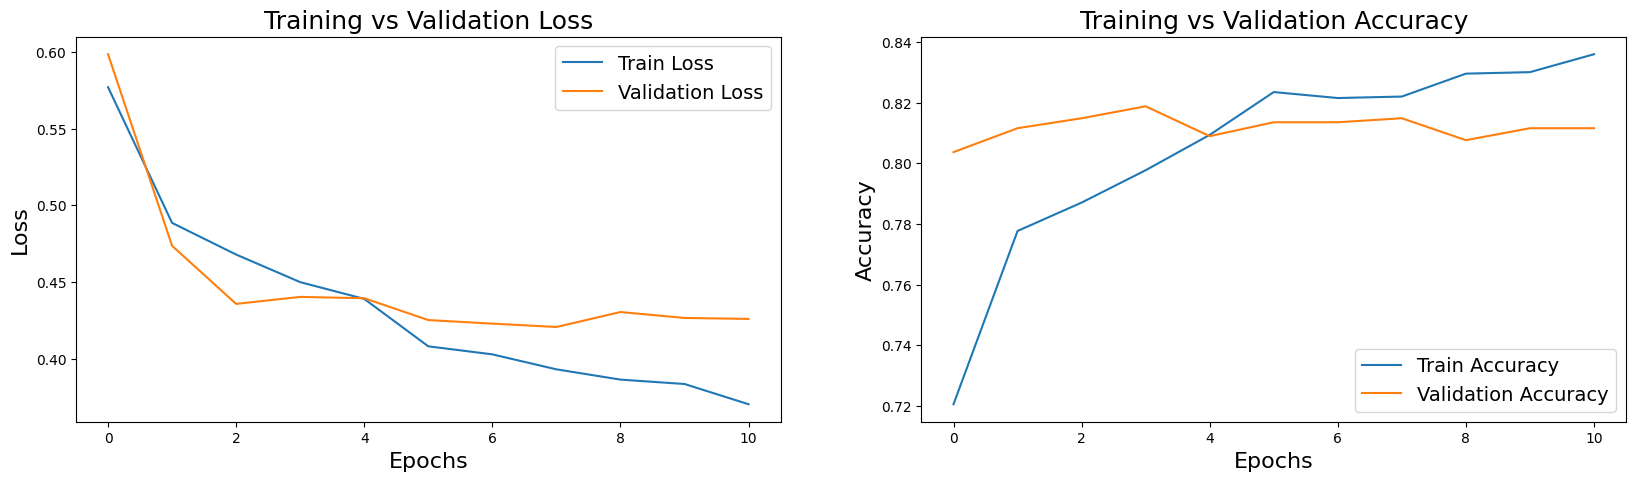

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Training vs Validation Loss', fontsize=18)
ax1.legend(fontsize=14)

# Plot Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set_title('Training vs Validation Accuracy', fontsize=18)
ax2.legend(fontsize=14)

# Show
plt.show()

In [59]:
pred_probs = model.predict(X_test)

# Converting probabilities into binary classes
preds = (pred_probs >= 0.6).astype(int)  # Umbral in 0.6 as default

# Verify dimensions of predictions and actual labels
print(f"Predicciones: {preds.shape}, Etiquetas: {y_test.shape}")

# Generate the classification report
print(classification_report(y_test, preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
Predicciones: (1523, 1), Etiquetas: (1523,)
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       874
           1       0.89      0.63      0.74       649

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.79      1523
weighted avg       0.82      0.81      0.80      1523



In [60]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

# Show results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8096
Precision: 0.8928
Recall: 0.6287
F1-Score: 0.7378


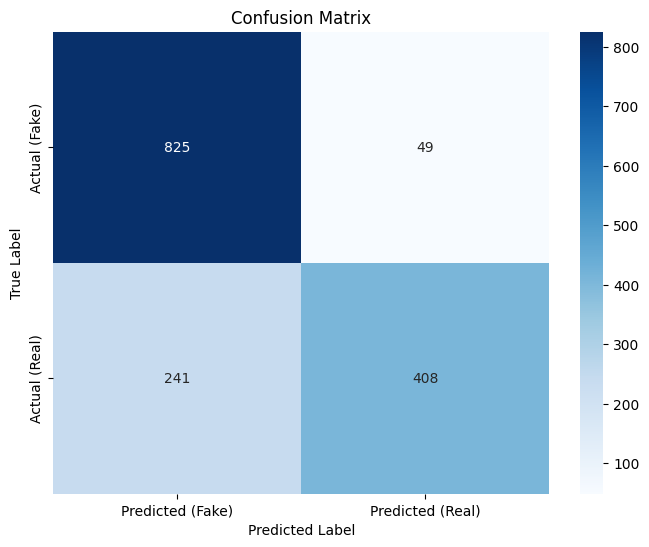

In [61]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted (Fake)', 'Predicted (Real)'],yticklabels=['Actual (Fake)', 'Actual (Real)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

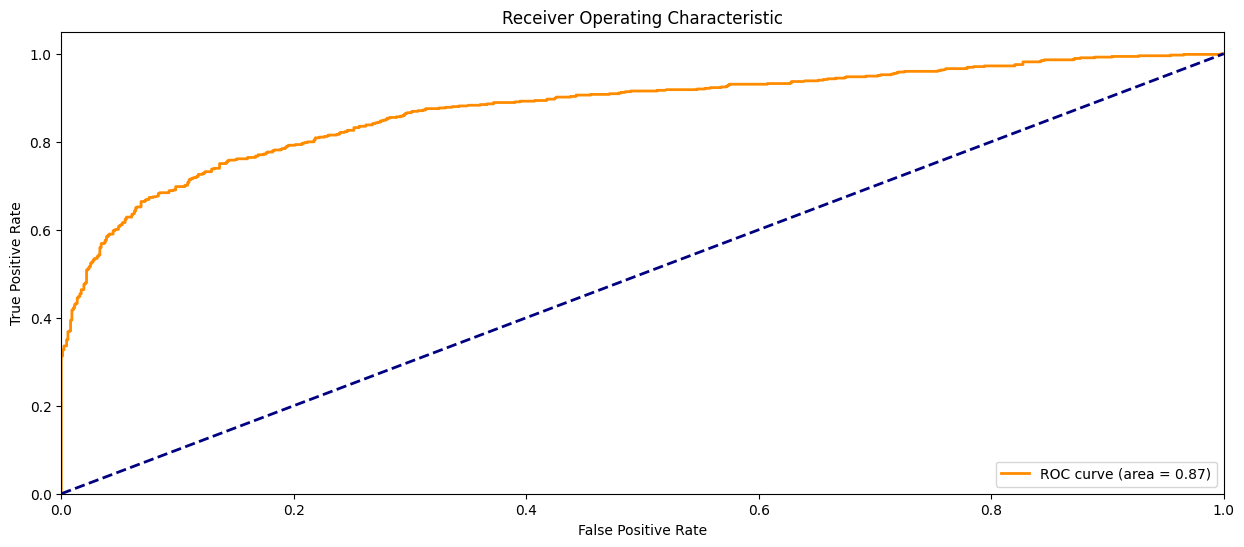

AUC: 0.8746963291527541


In [62]:
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")

##Test the Model##

In [63]:
test_tweets = test_dataset['text_clean'].values

pred_probs2 = model.predict(test_sentences)

# Converting probabilities into binary classes
preds2 = (pred_probs2 >= 0.6).astype(int)  # Umbral in 0.6



102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


In [64]:
results_df = pd.DataFrame({ 'Tweet': test_tweets,
    'Prediction': preds2.flatten(),
    'Label': ['REAL' if pred == 1 else 'FAKE' for pred in preds2.flatten()]
})
results_df

,Tweet,Prediction,Label
0,happened terrible car crash,1,REAL
1,heard earthquake different city stay safe ever...,1,REAL
2,forest fire spot pond goose fleeing across str...,1,REAL
3,apocalypse lighting spokane wildfire,1,REAL
4,typhoon soudelor kill china taiwan,1,REAL
...,...,...,...
3258,earthquake safety los angeles âãã safety fa...,1,REAL
3259,storm ri worse last hurricane city hardest hit...,1,REAL
3260,green line derailment chicago,1,REAL
3261,meg issue hazardous weather outlook hwo,0,FAKE


In [65]:
# Count 'REAL' and 'FAKE' values
real_count = (preds2 == 1).sum()
fake_count = (preds2 == 0).sum()

# Print the results
print(f"Tweets classified as REAL: {real_count}")
print(f"Tweets classified as FAKE: {fake_count}")

Tweets classified as REAL: 935
Tweets classified as FAKE: 2328


In [66]:
# Filter the first 20 tweets classified as 'REAL'.
real_tweets = results_df[results_df['Label'] == 'REAL'].head(20)
real_tweets


,Tweet,Prediction,Label
0,happened terrible car crash,1,REAL
1,heard earthquake different city stay safe ever...,1,REAL
2,forest fire spot pond goose fleeing across str...,1,REAL
3,apocalypse lighting spokane wildfire,1,REAL
4,typhoon soudelor kill china taiwan,1,REAL
5,shakingit earthquake,1,REAL
15,birmingham wholesale market ablaze bbc news fi...,1,REAL
23,rape victim dy set ablaze yearold girl died bu...,1,REAL
29,accident cleared paturnpike patp eb pa cranber...,1,REAL
34,trafficsouthe roadpoleast accident near lewes ...,1,REAL


In [67]:
# Filter the first 20 tweets classified as 'FAKE'.
fake_tweets = results_df[results_df['Label'] == 'FAKE'].tail(20)
fake_tweets

,Tweet,Prediction,Label
3221,interesting watching train wreck taking acid k...,0,FAKE
3222,dukeskywalker facialabuse competetion xxxmrboo...,0,FAKE
3224,wreck give ppl lifestyle advice,0,FAKE
3225,emotional wreck someone hold upload damn video...,0,FAKE
3226,added video youtube playlist burnt black nervo...,0,FAKE
3227,wreck uneven layer,0,FAKE
3228,dj wreck cut beat,0,FAKE
3229,herologist know right train wreck cannot belie...,0,FAKE
3241,cramer igers word wrecked disney stock,0,FAKE
3242,almost wrecked van day guy yeah brake also car...,0,FAKE
